#### Deepcut :
- this method uses Vision transformer extracted feature vectors as a graph where the feature vectors are the nodes and the feature vectors and the edges are the affinities between patches (cosine distance) 

In [26]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from PIL import Image
from transformers import ViTModel, ViTFeatureExtractor
from torch_geometric.data import Data
import torch_geometric.nn as pyg_nn
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# ---------------------------
# Graph Construction Function
# ---------------------------
def get_graph_data(image_path, model, feature_extractor, threshold=0.5, device='cpu'):
    """
    Given an input image path, this function loads the image, extracts ViT patch features,
    computes a pairwise affinity matrix (using cosine similarity), thresholds the affinities,
    and constructs a graph (in PyTorch Geometric Data format) where nodes represent image patches.
    
    Args:
        image_path (str): Path to the input image.
        model (ViTModel): A pretrained Vision Transformer model.
        feature_extractor (ViTFeatureExtractor): The feature extractor associated with the ViT model.
        threshold (float): Threshold to remove weak edges in the affinity matrix.
        device (str or torch.device): Device to use ('cpu' or 'cuda').
    
    Returns:
        data (torch_geometric.data.Data): Graph data object with fields:
            - x: Node feature matrix of shape [num_patches, hidden_dim]
            - edge_index: Edge index tensor of shape [2, num_edges]
            - edge_attr: Edge weight tensor of shape [num_edges]
        adjacency (torch.Tensor): The thresholded affinity (adjacency) matrix.
    """
    model.eval()
    model.to(device)
    
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=feature_extractor.image_mean, 
                             std=feature_extractor.image_std),
    ])
    
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)  # [1, 3, 224, 224]
    
    with torch.no_grad():
        outputs = model(image_tensor)
        features = outputs.last_hidden_state  # [1, num_patches+1, hidden_dim]
    
    patch_embeddings = features[:, 1:, :]  # Remove CLS token; [1, num_patches, hidden_dim]
    patch_feats = patch_embeddings.squeeze(0)  # [num_patches, hidden_dim]
    
    # Normalize for cosine similarity
    patch_feats_norm = F.normalize(patch_feats, p=2, dim=1)
    affinity = torch.mm(patch_feats_norm, patch_feats_norm.t())  # [num_patches, num_patches]
    affinity_thresholded = affinity.clone()
    affinity_thresholded[affinity_thresholded < threshold] = 0
    
    # Get edge_index and edge attributes
    edge_indices = (affinity_thresholded > 0).nonzero(as_tuple=False)  # [num_edges, 2]
    edge_index = edge_indices.t().contiguous()  # [2, num_edges]
    edge_attr = affinity_thresholded[edge_indices[:, 0], edge_indices[:, 1]]
    
    data = Data(x=patch_feats.cpu(), edge_index=edge_index.cpu(), edge_attr=edge_attr.cpu())
    return data, affinity_thresholded.cpu()

In [62]:
# ---------------------------
# Define the GNNpool model
# ---------------------------
class GNNnc(nn.Module):
    def __init__(self, input_dim, conv_hidden, mlp_hidden, num_clusters, device):
        """
        Implementation of a pooling GNN based on a mincutpool style approach.
        @param input_dim: Dimension of input node features.
        @param conv_hidden: Hidden dimension for the GCN convolution.
        @param mlp_hidden: Hidden dimension for the MLP.
        @param num_clusters: Number of clusters to output.
        @param device: Device to run the model on.
        """
        super(GNNnc, self).__init__()
        self.device = device
        self.num_clusters = num_clusters
        self.mlp_hidden = mlp_hidden

        # GCN layer (using torch_geometric's GCNConv)
        self.convs = pyg_nn.GCNConv(input_dim, conv_hidden)
        # MLP for cluster assignment
        self.mlp = nn.Sequential(
            nn.Linear(conv_hidden, mlp_hidden),
            nn.ELU(),
            nn.Dropout(0.25),
            nn.Linear(mlp_hidden, self.num_clusters)
        )

    def forward(self, data, A):
        """
        Forward pass.
        @param data: Graph in PyTorch Geometric Data format.
        @param A: Adjacency matrix of the graph.
        @return: The same A and the soft cluster assignment matrix S.
        """
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = self.convs(x, edge_index, edge_attr)  # GCN convolution
        x = F.elu(x)
        H = self.mlp(x)  # MLP for cluster assignments
        S = F.softmax(H, dim=1)  # Soft cluster assignment per node
        return A, S

    def loss(self, A, S):
        """
        Compute the relaxed normalized-cut loss.
        @param A: Adjacency matrix of the graph.
        @param S: Soft cluster assignment matrix.
        @return: Combined loss (mincut loss and orthogonality loss).
        """
        # Mincut loss: Encourage a low cut value relative to cluster connectivity.
        A_pool = torch.matmul(torch.matmul(A, S), S.t())
        num = torch.trace(A_pool)
        D = torch.diag(torch.sum(A, dim=-1))
        D_pool = torch.matmul(torch.matmul(D, S), S.t())
        den = torch.trace(D_pool)
        mincut_loss = -(num / den)

        # Orthogonality loss: Encourage clusters to be distinct and balanced.
        St_S = torch.matmul(S.t(), S)
        I_S = torch.eye(self.num_clusters, device=self.device)
        ortho_loss = torch.norm(St_S / torch.norm(St_S) - I_S / torch.norm(I_S))

        return mincut_loss + ortho_loss



In [63]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.nn as pyg_nn


class GNNcc(nn.Module):
    def __init__(self, input_dim, conv_hidden, mlp_hidden, num_clusters, device):
        """
        implementation of mincutpool model from: https://arxiv.org/pdf/1907.00481v6.pdf
        @param input_dim: Size of input nodes features
        @param conv_hidden: Size Of conv hidden layers
        @param mlp_hidden: Size of mlp hidden layers
        @param num_clusters: Number of cluster to output
        @param device: Device to run the model on
        """
        super(GNNcc, self).__init__()
        self.device = device
        self.num_clusters = num_clusters
        self.mlp_hidden = mlp_hidden

        # GNN conv
        self.convs = pyg_nn.GCN(input_dim, conv_hidden, 1, act='elu')
        # MLP
        self.mlp = nn.Sequential(
            nn.Linear(conv_hidden, mlp_hidden), nn.ELU(), nn.Dropout(0.25),
            nn.Linear(mlp_hidden, self.num_clusters))

    def forward(self, data, A):
        """
        forward pass of the model
        @param data: Graph in Pytorch geometric data format
        @param A: Adjacency matrix of the graph
        @return: Adjacency matrix of the graph and pooled graph (argmax of S)
        """
        x, edge_index, edge_atrr = data.x, data.edge_index, data.edge_attr

        x = self.convs(x, edge_index, edge_atrr)  # applying con5v
        x = F.elu(x)

        # pass feats through mlp
        H = self.mlp(x)

        # cluster assignment for matrix S
        S = F.softmax(H)

        return A, S

    def loss(self, A, S):
        """
        loss calculation, relaxed form of Normalized-cut
        @param A: Adjacency matrix of the graph
        @param S: Polled graph (argmax of S)
        @return: loss value
        """
        # cc loss
        X = torch.matmul(S, S.t())
        cc_loss = -torch.sum(A * X)

        return cc_loss

In [69]:
def segment_image(image_path , loss = 'nc'):
    # 1. Load the pre-trained ViT model and feature extractor.
    model_name = "facebook/dino-vitb8"
    vit_model = ViTModel.from_pretrained(model_name)
    vit_feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # 2. Build the graph data from the image.
    data, adjacency = get_graph_data(image_path, vit_model, vit_feature_extractor, threshold=0.5, device=device)
    print("Graph data:", data)
    print("Adjacency matrix shape:", adjacency.shape)

    # 3. Initialize the GNNpool model.
    num_clusters = 2  # For example, segmenting the image into two clusters (foreground/background)
    if loss == 'nc':
        model_gnn = GNNnc(input_dim=768, conv_hidden=64, mlp_hidden=32, num_clusters=num_clusters, device=device).to(device)
    else:
        model_gnn = GNNcc(input_dim=768, conv_hidden=64, mlp_hidden=32, num_clusters=num_clusters, device=device).to(device)

    # 4. Set up the optimizer.
    optimizer = optim.AdamW(model_gnn.parameters(), lr=0.001)

    # 5. Train the GNN on the graph for a number of epochs (test-time optimization).
    num_epochs = 128  # Adjust the number of epochs as needed
    model_gnn.train()
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        # Move data and adjacency to device.
        A, S = model_gnn(data.to(device), adjacency.to(device))
        loss = model_gnn.loss(adjacency.to(device), S)
        loss.backward()
        optimizer.step()
        # print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

    # 6. After training, obtain the soft cluster assignments S and get discrete cluster labels.
    model_gnn.eval()
    with torch.no_grad():
        _, S = model_gnn(data.to(device), adjacency.to(device))
    cluster_assignments = torch.argmax(S, dim=1)  # [num_patches]

    # 7. Reshape the cluster assignments into a patch-level segmentation map.
    num_patches = cluster_assignments.shape[0]  # expected to be 196 (14x14)
    grid_size = int(np.sqrt(num_patches))
    seg_map_patch = cluster_assignments.view(grid_size, grid_size).cpu().numpy()  # shape: [14, 14]

    # 8. Upsample the patch segmentation map to the original image resolution (224x224).
    seg_tensor = torch.tensor(seg_map_patch, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # [1, 1, 14, 14]
    seg_tensor_up = F.interpolate(seg_tensor, size=(224, 224), mode='nearest')  # Upsample using nearest-neighbor
    seg_map_up = seg_tensor_up.squeeze().cpu().numpy().astype(np.int32)  # shape: [224, 224]

    # 9. Load the original image for visualization (resize to 224x224 for consistency).
    orig_image = Image.open(image_path).convert("RGB")
    orig_image = orig_image.resize((224, 224))

    # 10. Display the segmentation overlaid on the original image.
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(orig_image)
    plt.title("Original Image")

    plt.subplot(1, 2, 2)
    plt.imshow(orig_image)
    plt.imshow(seg_map_up, cmap='jet', alpha=0.5)  # Overlay segmentation with transparency
    plt.title("Segmented Image (Upsampled)")
    plt.colorbar(label="Cluster ID")
    plt.show()

Processing pexels-diephotopotato-13938350.jpg with loss='nc'


Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vitb8 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/mohamed/.local/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Graph data: Data(x=[784, 768], edge_index=[2, 164562], edge_attr=[164562])
Adjacency matrix shape: torch.Size([784, 784])


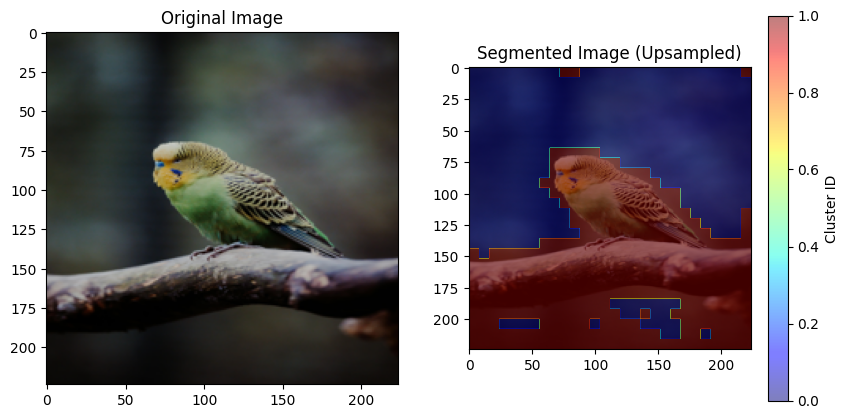

Processing pexels-diephotopotato-13938350.jpg with loss='cc'


Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vitb8 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Graph data: Data(x=[784, 768], edge_index=[2, 164562], edge_attr=[164562])
Adjacency matrix shape: torch.Size([784, 784])


/tmp/ipykernel_13320/3092524390.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  S = F.softmax(H)


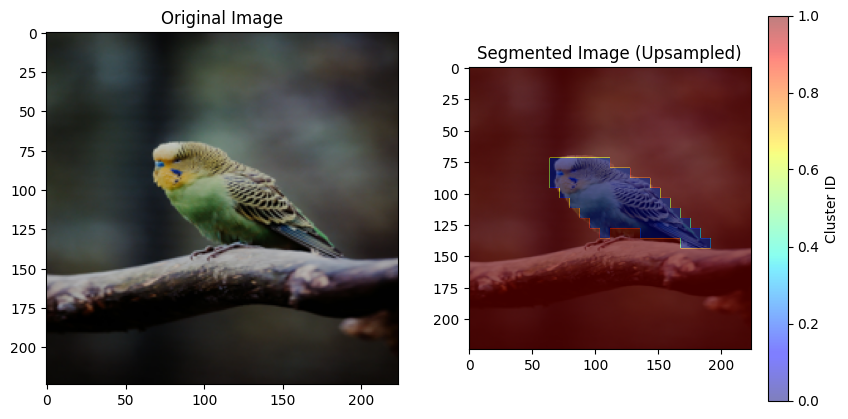

Processing pexels-svonhorst-2920064.jpg with loss='nc'


Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vitb8 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Graph data: Data(x=[784, 768], edge_index=[2, 55700], edge_attr=[55700])
Adjacency matrix shape: torch.Size([784, 784])


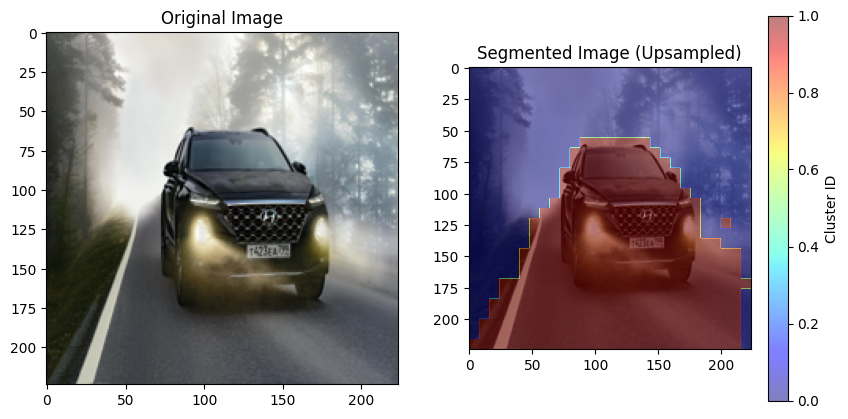

Processing pexels-svonhorst-2920064.jpg with loss='cc'


Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vitb8 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Graph data: Data(x=[784, 768], edge_index=[2, 55700], edge_attr=[55700])
Adjacency matrix shape: torch.Size([784, 784])


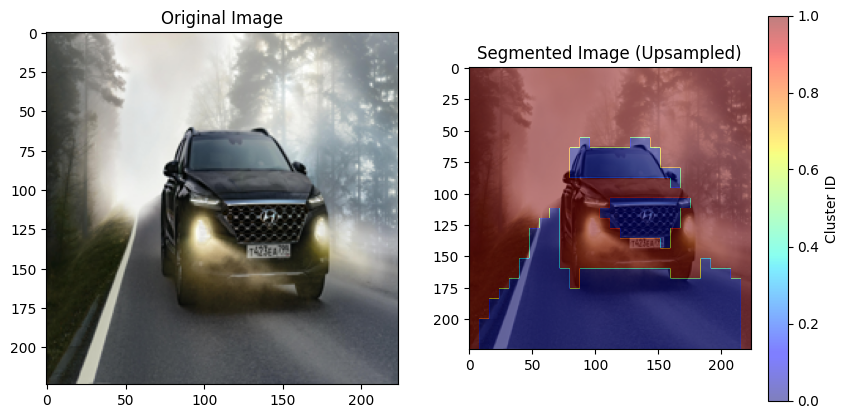

Processing pexels-pixabay-73825.jpg with loss='nc'


Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vitb8 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Graph data: Data(x=[784, 768], edge_index=[2, 349952], edge_attr=[349952])
Adjacency matrix shape: torch.Size([784, 784])


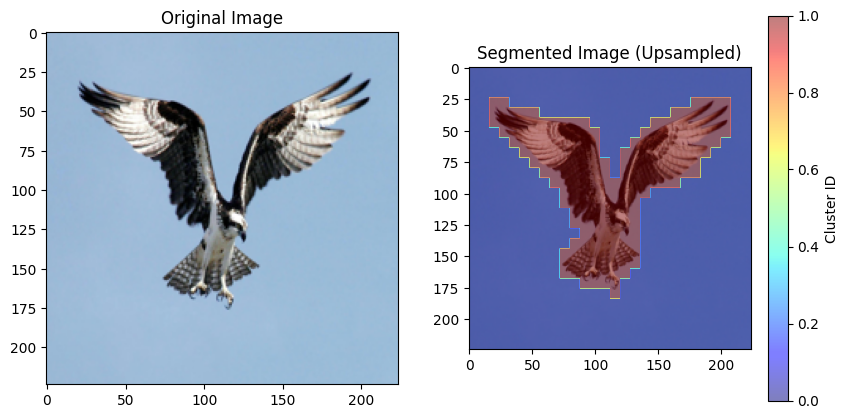

Processing pexels-pixabay-73825.jpg with loss='cc'


Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vitb8 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Graph data: Data(x=[784, 768], edge_index=[2, 349952], edge_attr=[349952])
Adjacency matrix shape: torch.Size([784, 784])


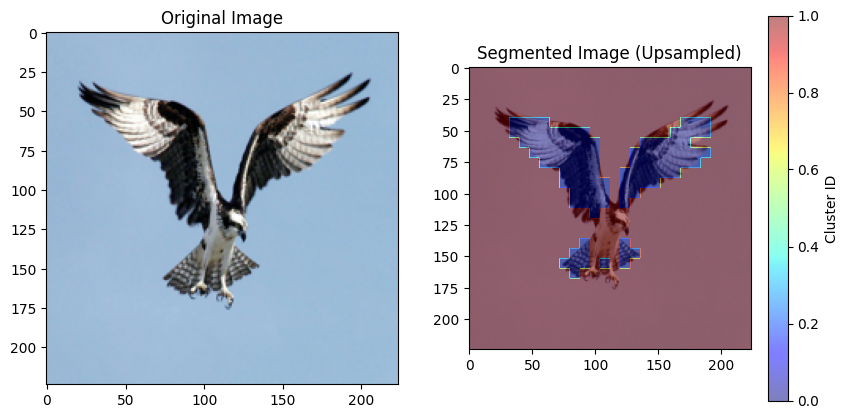

Processing pexels-roshan-kamath-793618-1661179.jpg with loss='nc'


Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vitb8 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Graph data: Data(x=[784, 768], edge_index=[2, 192598], edge_attr=[192598])
Adjacency matrix shape: torch.Size([784, 784])


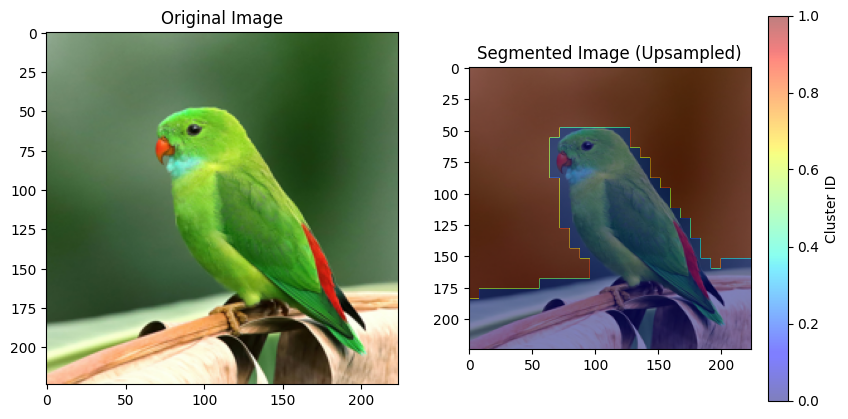

Processing pexels-roshan-kamath-793618-1661179.jpg with loss='cc'


Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vitb8 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Graph data: Data(x=[784, 768], edge_index=[2, 192598], edge_attr=[192598])
Adjacency matrix shape: torch.Size([784, 784])


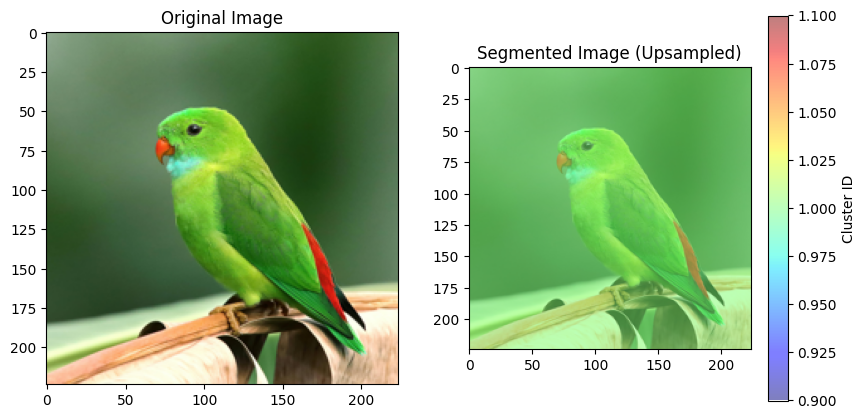

Processing pexels-padrinan-1453809.jpg with loss='nc'


Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vitb8 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Graph data: Data(x=[784, 768], edge_index=[2, 260664], edge_attr=[260664])
Adjacency matrix shape: torch.Size([784, 784])


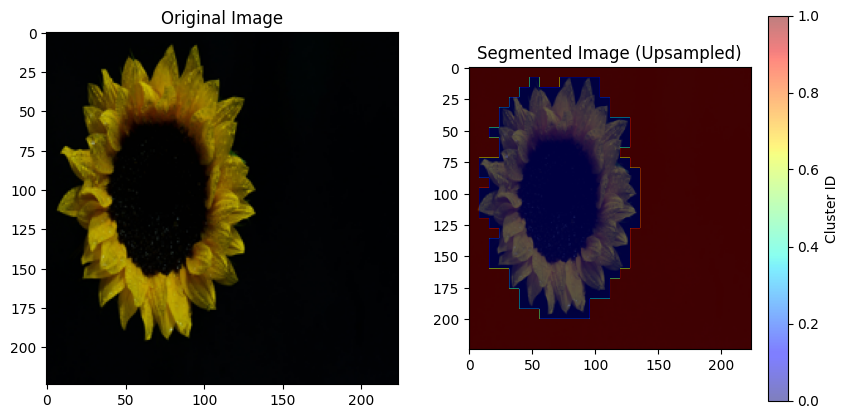

Processing pexels-padrinan-1453809.jpg with loss='cc'


Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vitb8 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Graph data: Data(x=[784, 768], edge_index=[2, 260664], edge_attr=[260664])
Adjacency matrix shape: torch.Size([784, 784])


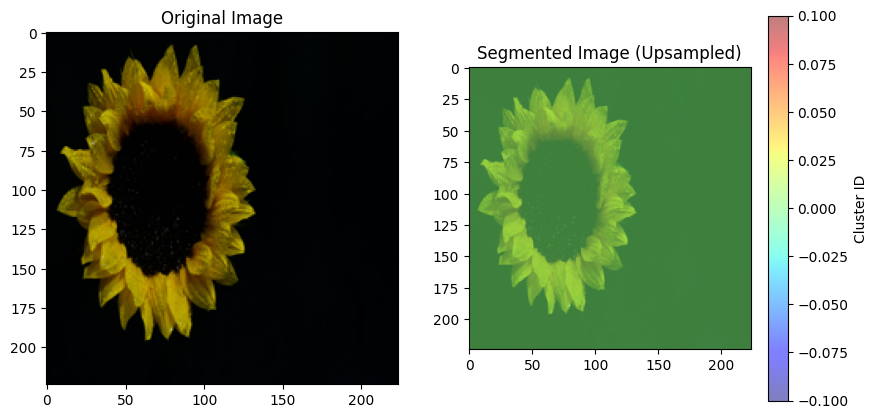

In [70]:
# Apply the segmentation to all images in the test_images directory
test_images_dir = "/home/mohamed/Desktop/prgnn/GNN/test_images"
for image_file in os.listdir(test_images_dir):
    image_path = os.path.join(test_images_dir, image_file)
    if os.path.isfile(image_path):
        print(f"Processing {image_file} with loss='nc'")
        segment_image(image_path, loss='nc')
        print(f"Processing {image_file} with loss='cc'")
        segment_image(image_path, loss='cc')

Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vitb8 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/mohamed/.local/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Graph data: Data(x=[784, 768], edge_index=[2, 54594], edge_attr=[54594])
Adjacency matrix shape: torch.Size([784, 784])


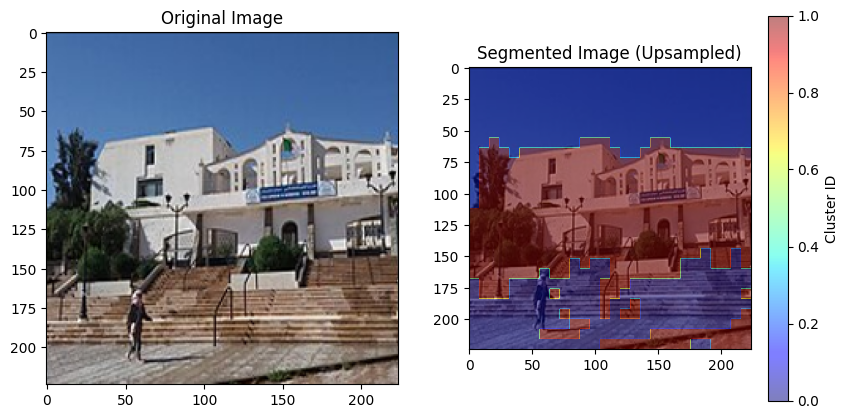

In [ ]:
segment_image("/home/mohamed/Desktop/prgnn/GNN/test_images/image.png", loss='nc')


Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vitb8 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Graph data: Data(x=[784, 768], edge_index=[2, 138548], edge_attr=[138548])
Adjacency matrix shape: torch.Size([784, 784])


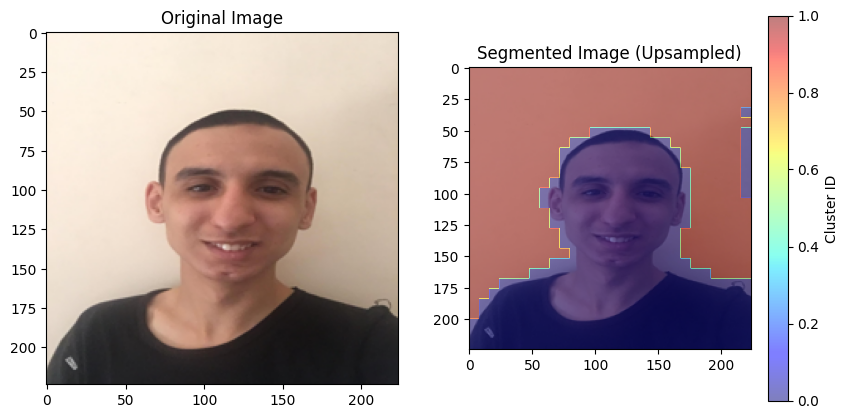

In [72]:
segment_image("/home/mohamed/Desktop/prgnn/GNN/test_images/slmn.jpg", loss='nc')
